# This notebook has an interactive version hosted at:

https://bit.ly/3caUN7n

# Install dependencies

In [ ]:
!pip install swiftgalaxy[velociraptor]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.2 MB/s eta 0:00:00


May need to restart runtime after installation!

# Create a simple toy-model snapshot and halo finder output

The following long block of code defines a couple of functions to create a sample snapshot and velociraptor output "by hand"; these are run in the next block to give us some lightweight data to experiment with.

The sample snapshot is a periodic simulation volume with a uniform background density of dark matter and gas. The box has a side length of 10 Mpc. At coordinates (2, 2, 2) Mpc is a very crude "galaxy" composed of:
 - a gas disc 10 kpc in radius and 2 kpc thick with 1/R surface density scaling and vertically uniform density
 - a spherical dark matter halo 100 kpc in radius with 1/r^2 density scaling
 - a stellar disc 5 kpc in radius and 1 kpc thick with 1/R surface density scaling and vertically uniform density
 - a central black hole

In [ ]:
import os
import h5py
import numpy as np
import unyt as u
from swiftsimio import Writer
from swiftsimio.units import cosmo_units

toysnap_filename = "toysnap.hdf5"
toyvr_filebase = "toyvr"
present_particle_types = {0: "gas", 1: "dark_matter", 4: "stars", 5: "black_holes"}
boxsize = 10.0
n_g_all = 32**3
n_g = 10000
n_g_b = n_g_all - n_g
n_dm_all = 32**3
n_dm = 10000
n_dm_b = n_dm_all - n_dm
n_s = 10000
n_bh = 1


def create_toysnap(
    snapfile=toysnap_filename, alt_coord_name=None, alt_vel_name=None, alt_id_name=None
):
    """
    Creates a sample dataset of a toy galaxy.
    """

    sd = Writer(cosmo_units, np.ones(3, dtype=float) * boxsize * u.Mpc)

    # Insert a uniform gas background plus a galaxy disc
    phi = np.random.rand(n_g, 1) * 2 * np.pi
    R = np.random.rand(n_g, 1)
    getattr(sd, present_particle_types[0]).particle_ids = np.arange(n_g_all)
    getattr(sd, present_particle_types[0]).coordinates = (
        np.vstack(
            (
                np.random.rand(n_g_b, 3) * 10,
                np.hstack(
                    (
                        # 10 kpc disc radius, offcentred in box
                        2 + R * np.cos(phi) * 0.01,
                        2 + R * np.sin(phi) * 0.01,
                        2 + (np.random.rand(n_g, 1) * 2 - 1) * 0.001,  # 1 kpc height
                    )
                ),
            )
        )
        * u.Mpc
    )
    getattr(sd, present_particle_types[0]).velocities = (
        np.vstack(
            (
                np.random.rand(n_g_b, 3) * 2 - 1,  # 1 km/s for background
                np.hstack(
                    (
                        # solid body, 100 km/s at edge
                        200 + R * np.sin(phi) * 100,
                        200 + R * np.cos(phi) * 100,
                        200 + np.random.rand(n_g, 1) * 20 - 10,  # 10 km/s vertical
                    )
                ),
            )
        )
        * u.km
        / u.s
    )
    getattr(sd, present_particle_types[0]).masses = (
        np.concatenate((np.ones(n_g_b, dtype=float), np.ones(n_g, dtype=float)))
        * 1e3
        * u.msun
    )
    getattr(sd, present_particle_types[0]).internal_energy = (
        np.concatenate(
            (
                np.ones(n_g_b, dtype=float),  # 1e4 K
                np.ones(n_g, dtype=float) / 10,  # 1e3 K
            )
        )
        * 1e4
        * u.kb
        * u.K
        / (1e3 * u.msun)
    )
    getattr(sd, present_particle_types[0]).generate_smoothing_lengths(
        boxsize=boxsize * u.Mpc, dimension=3
    )
    # Auto smoothing lengths ok for uniform background, reduce for disc particles
    getattr(sd, present_particle_types[0]).smoothing_length[n_g_b:] = 0.0001  # 100 pc

    # Insert a uniform DM background plus a galaxy halo
    phi = np.random.rand(n_dm, 1) * 2 * np.pi
    theta = np.arccos(np.random.rand(n_dm, 1) * 2 - 1)
    r = np.random.rand(n_dm, 1)
    getattr(sd, present_particle_types[1]).particle_ids = np.arange(
        n_g_all, n_g_all + n_dm_all
    )
    getattr(sd, present_particle_types[1]).coordinates = (
        np.vstack(
            (
                np.random.rand(n_dm_b, 3) * 10,
                np.hstack(
                    (
                        # 100 kpc halo radius, offcentred in box
                        2 + r * np.cos(phi) * np.sin(theta) * 0.1,
                        2 + r * np.sin(phi) * np.sin(theta) * 0.1,
                        2 + r * np.cos(theta) * 0.1,
                    )
                ),
            )
        )
        * u.Mpc
    )
    getattr(sd, present_particle_types[1]).velocities = (
        np.vstack(
            (
                # 1 km/s background, 100 km/s halo
                np.random.rand(n_dm_b, 3) * 2 - 1,
                200 + (np.random.rand(n_dm, 3) * 2 - 1) * 100,
            )
        )
        * u.km
        / u.s
    )
    getattr(sd, present_particle_types[1]).masses = (
        np.concatenate((np.ones(n_dm_b, dtype=float), np.ones(n_dm, dtype=float)))
        * 1e4
        * u.msun
    )
    getattr(sd, present_particle_types[1]).generate_smoothing_lengths(
        boxsize=boxsize * u.Mpc, dimension=3
    )

    # Insert a galaxy stellar disc
    phi = np.random.rand(n_s, 1) * 2 * np.pi
    R = np.random.rand(n_s, 1)
    getattr(sd, present_particle_types[4]).particle_ids = np.arange(
        n_g_all + n_dm_all, n_g_all + n_dm_all + n_s
    )
    getattr(sd, present_particle_types[4]).coordinates = (
        np.hstack(
            (
                # 5 kpc disc radius, offcentred in box
                2 + R * np.cos(phi) * 0.005,
                2 + R * np.sin(phi) * 0.005,
                2 + (np.random.rand(n_s, 1) * 2 - 1) * 0.0005,  # 500 pc height
            )
        )
        * u.Mpc
    )
    getattr(sd, present_particle_types[4]).velocities = (
        np.hstack(
            (
                # solid body, 50 km/s at edge
                200 + R * np.sin(phi) * 50,
                200 + R * np.cos(phi) * 50,
                200 + np.random.rand(n_g, 1) * 20 - 10,  # 10 km/s vertical motions
            )
        )
        * u.km
        / u.s
    )
    getattr(sd, present_particle_types[4]).masses = (
        np.ones(n_g, dtype=float) * 1e3 * u.msun
    )
    getattr(sd, present_particle_types[4]).generate_smoothing_lengths(
        boxsize=boxsize * u.Mpc, dimension=3
    )
    getattr(sd, present_particle_types[5]).particle_ids = np.arange(
        n_g_all + n_dm_all + n_s, n_g_all + n_dm_all + n_s + n_bh
    )
    getattr(sd, present_particle_types[5]).coordinates = (
        2 + np.zeros((n_bh, 3), dtype=float)
    ) * u.Mpc
    getattr(sd, present_particle_types[5]).velocities = (
        (200 + np.zeros((n_bh, 3), dtype=float)) * u.km / u.s
    )
    getattr(sd, present_particle_types[5]).masses = (
        np.ones(n_bh, dtype=float) * 1e6 * u.msun
    )
    getattr(sd, present_particle_types[5]).generate_smoothing_lengths(
        boxsize=boxsize * u.Mpc, dimension=3
    )

    sd.write(snapfile)  # IDs auto-generated

    with h5py.File(snapfile, "r+") as f:
        g = f.create_group("Cells")
        g.create_dataset("Centres", data=np.array([[5, 5, 5]], dtype=float))
        cg = g.create_group("Counts")
        cg.create_dataset("PartType0", data=np.array([n_g_all]), dtype=int)
        cg.create_dataset("PartType1", data=np.array([n_dm_all]), dtype=int)
        cg.create_dataset("PartType4", data=np.array([n_s]), dtype=int)
        cg.create_dataset("PartType5", data=np.array([n_bh]), dtype=int)
        fg = g.create_group("Files")
        fg.create_dataset("PartType0", data=np.array([0], dtype=int))
        fg.create_dataset("PartType1", data=np.array([0], dtype=int))
        fg.create_dataset("PartType4", data=np.array([0], dtype=int))
        fg.create_dataset("PartType5", data=np.array([0], dtype=int))
        mdg = g.create_group("Meta-data")
        mdg.attrs["dimension"] = np.array([[1, 1, 1]], dtype=int)
        mdg.attrs["nr_cells"] = np.array([1], dtype=int)
        mdg.attrs["size"] = np.array([boxsize, boxsize, boxsize], dtype=int)
        og = g.create_group("OffsetsInFile")
        og.create_dataset("PartType0", data=np.array([0], dtype=int))
        og.create_dataset("PartType1", data=np.array([0], dtype=int))
        og.create_dataset("PartType4", data=np.array([0], dtype=int))
        og.create_dataset("PartType5", data=np.array([0], dtype=int))
        hsg = f.create_group("HydroScheme")
        hsg.attrs["Adiabatic index"] = 5.0 / 3.0

        for pt in (0, 1, 4, 5):
            g = f[f"PartType{pt}"]
            g["ExtraCoordinates"] = g["Coordinates"]
            g["ExtraVelocities"] = g["Velocities"]
            if alt_id_name is not None:
                g[alt_id_name] = g["ParticleIDs"]
                del g["ParticleIDs"]
            if alt_coord_name is not None:
                g[alt_coord_name] = g["Coordinates"]
                del g["Coordinates"]
            if alt_vel_name is not None:
                g[alt_vel_name] = g["Velocities"]
                del g["Velocities"]

        ssg = f.create_group("SubgridScheme")
        ncg = ssg.create_group("NamedColumns")
        ncg.create_dataset(
            "HydrogenIonizationFractions",
            data=np.array([b"Neutral", b"Ionized"], dtype="|S32"),
        )
        g = f["PartType0"]
        f_neutral = np.random.rand(n_g_all)
        f_ion = 1 - f_neutral
        hifd = g.create_dataset(
            "HydrogenIonizationFractions",
            data=np.array([f_neutral, f_ion], dtype=float).T,
        )
        hifd.attrs[
            "Conversion factor to CGS" " (not including cosmological corrections)"
        ] = np.array([1.0], dtype=float)
        hifd.attrs[
            "Conversion factor to physical CGS" " (including cosmological corrections)"
        ] = np.array([1.0], dtype=float)
        hifd.attrs["U_I exponent"] = np.array([0.0], dtype=float)
        hifd.attrs["U_L exponent"] = np.array([0.0], dtype=float)
        hifd.attrs["U_M exponent"] = np.array([0.0], dtype=float)
        hifd.attrs["U_T exponent"] = np.array([0.0], dtype=float)
        hifd.attrs["U_t exponent"] = np.array([0.0], dtype=float)
        hifd.attrs["a-scale exponent"] = np.array([0.0], dtype=float)
        hifd.attrs["h-scale exponent"] = np.array([0.0], dtype=float)

    return


def remove_toysnap(snapfile=toysnap_filename):
    os.remove(snapfile)
    return


def create_toyvr(filebase=toyvr_filebase):
    with h5py.File(f"{toyvr_filebase}.properties", "w") as f:
        f.create_group("SimulationInfo")
        f["SimulationInfo"].attrs["ScaleFactor"] = 1.0
        f["SimulationInfo"].attrs["Cosmological_Sim"] = 1
        for coord in "XYZ":
            f.create_dataset(f"{coord}c", data=np.array([2.001], dtype=float))
            f.create_dataset(f"{coord}cminpot", data=np.array([2.0], dtype=float))
            f.create_dataset(f"{coord}cmbp", data=np.array([2.002], dtype=float))
            f.create_dataset(f"{coord}c_gas", data=np.array([0.003], dtype=float))
            f.create_dataset(f"{coord}c_stars", data=np.array([0.004], dtype=float))
            f.create_dataset(f"V{coord}c", data=np.array([201.0], dtype=float))
            f.create_dataset(f"V{coord}cminpot", data=np.array([200.0], dtype=float))
            f.create_dataset(f"V{coord}cmbp", data=np.array([202.0], dtype=float))
            f.create_dataset(f"V{coord}c_gas", data=np.array([3.0], dtype=float))
            f.create_dataset(f"V{coord}c_stars", data=np.array([4.0], dtype=float))
            for ct in ("c", "cminpot", "cmbp", "c_gas", "c_stars"):
                f[f"{coord}{ct}"].attrs["Dimension_Length"] = 1.0
                f[f"{coord}{ct}"].attrs["Dimension_Mass"] = 0.0
                f[f"{coord}{ct}"].attrs["Dimension_Time"] = 0.0
                f[f"{coord}{ct}"].attrs["Dimension_Velocity"] = 0.0
                f[f"V{coord}{ct}"].attrs["Dimension_Length"] = 0.0
                f[f"V{coord}{ct}"].attrs["Dimension_Mass"] = 0.0
                f[f"V{coord}{ct}"].attrs["Dimension_Time"] = 0.0
                f[f"V{coord}{ct}"].attrs["Dimension_Velocity"] = 1.0
        f.create_group("Configuration")
        f["Configuration"].attrs["h_val"] = 0.7
        f["Configuration"].attrs["w_of_DE"] = -1.0
        f["Configuration"].attrs["Omega_DE"] = 0.7
        f["Configuration"].attrs["Omega_b"] = 0.05
        f["Configuration"].attrs["Omega_m"] = 0.3
        f["Configuration"].attrs["Period"] = boxsize
        f.create_dataset("File_id", data=np.array([0], dtype=int))
        f.create_dataset("ID", data=np.array([1], dtype=int))
        f["ID"].attrs["Dimension_Length"] = 0.0
        f["ID"].attrs["Dimension_Mass"] = 0.0
        f["ID"].attrs["Dimension_Time"] = 0.0
        f["ID"].attrs["Dimension_Velocity"] = 0.0
        # pick arbitrary particle in the galaxy to be most bound
        f.create_dataset("ID_mbp", data=np.array([32**3 - 9999], dtype=int))
        f["ID_mbp"].attrs["Dimension_Length"] = 0.0
        f["ID_mbp"].attrs["Dimension_Mass"] = 0.0
        f["ID_mbp"].attrs["Dimension_Time"] = 0.0
        f["ID_mbp"].attrs["Dimension_Velocity"] = 0.0
        # pick arbitrary particle in the galaxy to be potential minimum
        f.create_dataset("ID_minpot", data=np.array([32**3 - 9998], dtype=int))
        f["ID_minpot"].attrs["Dimension_Length"] = 0.0
        f["ID_minpot"].attrs["Dimension_Mass"] = 0.0
        f["ID_minpot"].attrs["Dimension_Time"] = 0.0
        f["ID_minpot"].attrs["Dimension_Velocity"] = 0.0
        f.create_dataset("Mvir", data=np.array([100.0], dtype=float))
        f.create_dataset("Mass_200crit", data=np.array([100.0], dtype=float))
        f.create_dataset("Mass_200mean", data=np.array([100.0], dtype=float))
        f.create_dataset("Mass_BN98", data=np.array([100.0], dtype=float))
        f.create_dataset("Mass_FOF", data=np.array([100.0], dtype=float))
        for field in ("Mvir", "Mass_200crit", "Mass_200mean", "Mass_BN98", "Mass_FOF"):
            f[field].attrs["Dimension_Length"] = 0.0
            f[field].attrs["Dimension_Mass"] = 1.0
            f[field].attrs["Dimension_Time"] = 0.0
            f[field].attrs["Dimension_Velocity"] = 0.0
        f.create_dataset("R_200crit", data=np.array([0.3], dtype=float))
        f.create_dataset("R_200mean", data=np.array([0.3], dtype=float))
        f.create_dataset("R_BN98", data=np.array([0.3], dtype=float))
        f.create_dataset("R_size", data=np.array([0.3], dtype=float))
        f.create_dataset("Rmax", data=np.array([0.3], dtype=float))
        f.create_dataset("Rvir", data=np.array([0.3], dtype=float))
        for field in ("R_200crit", "R_200mean", "R_BN98", "R_size", "Rmax", "Rvir"):
            f[field].attrs["Dimension_Length"] = 1.0
            f[field].attrs["Dimension_Mass"] = 0.0
            f[field].attrs["Dimension_Time"] = 0.0
            f[field].attrs["Dimension_Velocity"] = 0.0
        f.create_dataset("Num_of_files", data=np.array([1], dtype=int))
        f.create_dataset("Num_of_groups", data=np.array([1], dtype=int))
        f.create_dataset("Structuretype", data=np.array([10], dtype=int))
        f["Structuretype"].attrs["Dimension_Length"] = 0.0
        f["Structuretype"].attrs["Dimension_Mass"] = 0.0
        f["Structuretype"].attrs["Dimension_Time"] = 0.0
        f["Structuretype"].attrs["Dimension_Velocity"] = 0.0
        f.create_dataset("Total_num_of_groups", data=np.array([1], dtype=int))
        f.create_group("UnitInfo")
        # have not checked UnitInfo in detail
        f["UnitInfo"].attrs["Comoving_or_Physical"] = b"0"
        f["UnitInfo"].attrs["Cosmological_Sim"] = b"1"
        f["UnitInfo"].attrs["Length_unit_to_kpc"] = b"1000.000000"
        f["UnitInfo"].attrs["Mass_unit_to_solarmass"] = b"10000000000.000000"
        f["UnitInfo"].attrs["Metallicity_unit_to_solar"] = b"83.330000"
        f["UnitInfo"].attrs["SFR_unit_to_solarmassperyear"] = b"97.780000"
        f["UnitInfo"].attrs["Stellar_age_unit_to_yr"] = b"977813413600.000000"
        f["UnitInfo"].attrs["Velocity_unit_to_kms"] = b"1.000000"
        f.attrs["Comoving_or_Physical"] = 0
        f.attrs["Cosmological_Sim"] = 1
        f.attrs["Length_unit_to_kpc"] = 1000.000000
        f.attrs["Mass_unit_to_solarmass"] = 10000000000.000000
        f.attrs["Metallicity_unit_to_solar"] = 83.330000
        f.attrs["Period"] = boxsize
        f.attrs["SFR_unit_to_solarmassperyear"] = 97.780000
        f.attrs["Stellar_age_unit_to_yr"] = 977813413600.000000
        f.attrs["Time"] = 1.0
        f.attrs["Velocity_to_kms"] = 1.000000
        f.create_dataset("hostHaloID", data=np.array([-1], dtype=int))
        f["hostHaloID"].attrs["Dimension_Length"] = 0.0
        f["hostHaloID"].attrs["Dimension_Mass"] = 0.0
        f["hostHaloID"].attrs["Dimension_Time"] = 0.0
        f["hostHaloID"].attrs["Dimension_Velocity"] = 0.0
        f.create_dataset("n_bh", data=np.array([n_bh], dtype=int))
        f.create_dataset("n_gas", data=np.array([n_g], dtype=int))
        f.create_dataset("n_star", data=np.array([n_s], dtype=int))
        f.create_dataset("npart", data=np.array([n_g + n_dm + n_s + n_bh], dtype=int))
        for pt in ("_bh", "_gas", "_star", "part"):
            f[f"n{pt}"].attrs["Dimension_Length"] = 0.0
            f[f"n{pt}"].attrs["Dimension_Mass"] = 0.0
            f[f"n{pt}"].attrs["Dimension_Time"] = 0.0
            f[f"n{pt}"].attrs["Dimension_Velocity"] = 0.0
        f.create_dataset("numSubStruct", data=np.array([0], dtype=int))
        f["numSubStruct"].attrs["Dimension_Length"] = 0.0
        f["numSubStruct"].attrs["Dimension_Mass"] = 0.0
        f["numSubStruct"].attrs["Dimension_Time"] = 0.0
        f["numSubStruct"].attrs["Dimension_Velocity"] = 0.0
    with h5py.File(f"{toyvr_filebase}.catalog_groups", "w") as f:
        f.create_dataset("File_id", data=np.array([0], dtype=int))
        f.create_dataset(
            "Group_Size", data=np.array([n_g_all + n_dm_all + n_s + n_bh], dtype=int)
        )
        f.create_dataset("Num_of_files", data=np.array([1], dtype=int))
        f.create_dataset("Num_of_groups", data=np.array([1], dtype=int))
        f.create_dataset(
            "Number_of_substructures_in_halo", data=np.array([0], dtype=int)
        )
        f.create_dataset("Offset", data=np.array([0], dtype=int))
        f.create_dataset("Offset_unbound", data=np.array([0], dtype=int))
        f.create_dataset("Parent_halo_ID", data=np.array([-1], dtype=int))
        f.create_dataset("Total_num_of_groups", data=np.array([1], dtype=int))
    with h5py.File(f"{toyvr_filebase}.catalog_particles", "w") as f:
        f.create_dataset("File_id", data=np.array([0], dtype=int))
        f.create_dataset("Num_of_files", data=np.array([1], dtype=int))
        f.create_dataset(
            "Num_of_particles_in_groups",
            data=np.array([n_g + n_dm + n_s + n_bh], dtype=int),
        )
        f.create_dataset(
            "Particle_IDs",
            data=np.concatenate(
                (
                    np.arange(n_g_b, n_g_all, dtype=int),
                    np.arange(n_g_all + n_dm_b, n_g_all + n_dm_all, dtype=int),
                    np.arange(n_g_all + n_dm_all, n_g_all + n_dm_all + n_s, dtype=int),
                    np.arange(
                        n_g_all + n_dm_all + n_s,
                        n_g_all + n_dm_all + n_s + n_bh,
                        dtype=int,
                    ),
                )
            ),
        )
        f.create_dataset(
            "Total_num_of_particles_in_all_groups",
            data=np.array([n_g + n_dm + n_s + n_bh], dtype=int),
        )
    with h5py.File(f"{toyvr_filebase}.catalog_particles.unbound", "w") as f:
        f.create_dataset("File_id", data=np.array([0], dtype=int))
        f.create_dataset("Num_of_files", data=np.array([1], dtype=int))
        f.create_dataset(
            "Num_of_particles_in_groups", data=np.array([n_g_b + n_dm_b], dtype=int)
        )
        f.create_dataset(
            "Particle_IDs",
            data=np.concatenate(
                (
                    np.arange(n_g_b, dtype=int),
                    np.arange(n_g_all, n_g_all + n_dm_b, dtype=int),
                )
            ),
        )
        f.create_dataset(
            "Total_num_of_particles_in_all_groups",
            data=np.array([n_g_b + n_dm_b], dtype=int),
        )
    with h5py.File(f"{toyvr_filebase}.catalog_parttypes", "w") as f:
        f.create_dataset("File_id", data=np.array([0], dtype=int))
        f.create_dataset("Num_of_files", data=np.array([1], dtype=int))
        f.create_dataset(
            "Num_of_particles_in_groups",
            data=np.array([n_g + n_dm, +n_s + n_bh], dtype=int),
        )
        f.create_dataset(
            "Particle_types",
            data=np.concatenate(
                (
                    0 * np.ones(n_g, dtype=int),
                    1 * np.ones(n_dm, dtype=int),
                    4 * np.ones(n_s, dtype=int),
                    5 * np.ones(n_bh, dtype=int),
                )
            ),
        )
        f.create_dataset(
            "Total_num_of_particles_in_all_groups",
            data=np.array([n_g + n_dm + n_s + n_bh], dtype=int),
        )
    with h5py.File(f"{toyvr_filebase}.catalog_parttypes.unbound", "w") as f:
        f.create_dataset("File_id", data=np.array([0], dtype=int))
        f.create_dataset("Num_of_files", data=np.array([1], dtype=int))
        f.create_dataset(
            "Num_of_particles_in_groups", data=np.array([n_g_b + n_dm_b], dtype=int)
        )
        f.create_dataset(
            "Particle_types",
            data=np.concatenate(
                (0 * np.ones(n_g_b, dtype=int), 1 * np.ones(n_dm_b, dtype=int))
            ),
        )
        f.create_dataset(
            "Total_num_of_particles_in_all_groups",
            data=np.array([n_g_b + n_dm_b], dtype=int),
        )
    return


def remove_toyvr(filebase=toyvr_filebase):
    os.remove(f"{toyvr_filebase}.properties")
    os.remove(f"{toyvr_filebase}.catalog_groups")
    os.remove(f"{toyvr_filebase}.catalog_particles")
    os.remove(f"{toyvr_filebase}.catalog_particles.unbound")
    os.remove(f"{toyvr_filebase}.catalog_parttypes")
    os.remove(f"{toyvr_filebase}.catalog_parttypes.unbound")
    return

In [ ]:
create_toysnap()
create_toyvr()

# Start tutorial

## Initial setup

In this section we import required modules, and make a quick visualisation (using `swiftsimio`) of the snapshot where our galaxy lives.

First let's import the two basic pieces needed to set up a `SWIFTGalaxy`: the `SWIFTGalaxy` class itself, and a halo finder class from `swiftgalaxy`, in this case `Velociraptor`.

In [ ]:
from swiftgalaxy import SWIFTGalaxy, Velociraptor

We'll also import some `swiftsimio` and `matplotlib` things for visualisation purposes.

In [ ]:
from swiftsimio import SWIFTDataset
from swiftsimio.visualisation.projection import project_gas, project_pixel_grid
from swiftsimio.visualisation.smoothing_length_generation import (
    generate_smoothing_lengths,
)  # if not found try `from swiftsimio.visualisation import generate_smoothing_lengths`
import matplotlib.pyplot as plt
import matplotlib.colors

Let's load up our snapshot file in a `SWIFTDataset` (from swiftsimio) so that we can have a quick look at the contents.

In [ ]:
sd = SWIFTDataset(toysnap_filename)

We can use the `swiftsimio` visualisation tools to make `x-y`, `y-z` and `x-z` projections of the snapshot, and plot them.

Text(0.5, 0.98, 'gas density')

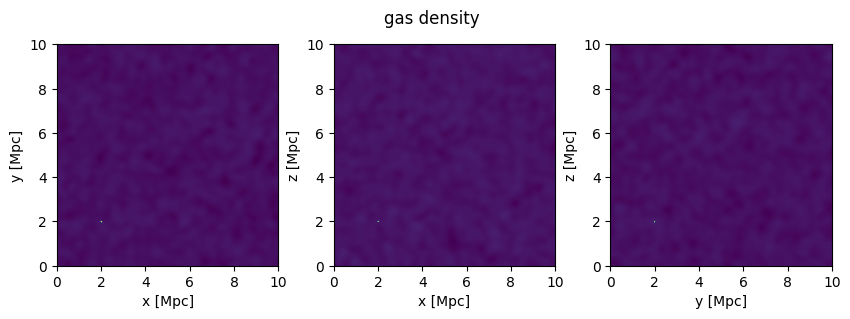

In [ ]:
boxsize = sd.metadata.boxsize
img_extent = [0, boxsize[0], 0, boxsize[0]]
box_centre = boxsize / 2

mass_map_xy = project_gas(
    sd,
    resolution=256,
    project="masses",
    parallel=True,
)
mass_map_xz = project_gas(
    sd,
    resolution=256,
    project="masses",
    parallel=True,
    rotation_matrix=[[0, 0, 1], [0, 1, 0], [-1, 0, 0]],
    rotation_center=box_centre,
)
mass_map_yz = project_gas(
    sd,
    resolution=256,
    project="masses",
    parallel=True,
    rotation_matrix=[[1, 0, 0], [0, 0, 1], [0, -1, 0]],
    rotation_center=box_centre,
)
for mass_map in mass_map_xy, mass_map_xz, mass_map_yz:
    mass_map.convert_to_units(u.Msun / u.kpc**2)

fig = plt.figure(1, figsize=(10, 3))
sp1, sp2, sp3 = [fig.add_subplot(1, 3, i) for i in range(1, 4)]
sp1.imshow(
    matplotlib.colors.LogNorm()(mass_map_xy.value),
    cmap="viridis",
    extent=img_extent,
    origin="lower",
)
sp1.set_xlabel(f"x [{boxsize.units}]")
sp1.set_ylabel(f"y [{boxsize.units}]")
sp2.imshow(
    matplotlib.colors.LogNorm()(mass_map_xz.value),
    cmap="viridis",
    extent=img_extent,
    origin="lower",
)
sp2.set_xlabel(f"x [{boxsize.units}]")
sp2.set_ylabel(f"z [{boxsize.units}]")
sp3.imshow(
    matplotlib.colors.LogNorm()(mass_map_yz.value),
    cmap="viridis",
    extent=img_extent,
    origin="lower",
)
sp3.set_xlabel(f"y [{boxsize.units}]")
sp3.set_ylabel(f"z [{boxsize.units}]")
fig.subplots_adjust(wspace=0.25)
fig.suptitle("gas density")

We can just barely make out a dot at (2, 2, 2) Mpc in the figure: the one galaxy in the snapshot.

Let's also define a function accepting a `SWIFTGalaxy` that we can use below to quickly plot a visualisation of the galaxy.

In [ ]:
def myvis(sg):
    disc_radius = 15 * u.kpc
    disc_region = [-disc_radius, disc_radius, -disc_radius, disc_radius]
    halo_radius = 200 * u.kpc
    halo_region = [-halo_radius, halo_radius, -halo_radius, halo_radius]
    gas_map = project_gas(
        sg,
        resolution=256,
        project="masses",
        parallel=True,
        region=disc_region,
    )
    dm_map = project_pixel_grid(
        data=sg.dark_matter,
        boxsize=sg.metadata.boxsize,
        resolution=256,
        project="masses",
        parallel=True,
        region=halo_region,
    )
    star_map = project_pixel_grid(
        data=sg.stars,
        boxsize=sg.metadata.boxsize,
        resolution=256,
        project="masses",
        parallel=True,
        region=disc_region,
    )

    fig = plt.figure(1, figsize=(10, 3))
    sp1, sp2, sp3 = [fig.add_subplot(1, 3, i) for i in range(1, 4)]
    sp1.imshow(
        matplotlib.colors.LogNorm()(gas_map.value), cmap="viridis", extent=disc_region
    )
    sp1.set_xlabel(f"x' [{disc_radius.units}]")
    sp1.set_ylabel(f"y' [{disc_radius.units}]")
    sp1.text(0.9, 0.9, "gas", ha="right", va="top", transform=sp1.transAxes)
    sp2.imshow(
        matplotlib.colors.LogNorm()(dm_map),
        cmap="inferno",
        extent=halo_region,
    )
    sp2.plot(
        [-disc_radius, -disc_radius, disc_radius, disc_radius, -disc_radius],
        [-disc_radius, disc_radius, disc_radius, -disc_radius, -disc_radius],
        "-k",
    )
    sp2.set_xlabel(f"x' [{halo_radius.units}]")
    sp2.set_ylabel(f"y' [{halo_radius.units}]")
    sp2.text(0.9, 0.9, "DM", ha="right", va="top", transform=sp2.transAxes)
    sp3.imshow(
        matplotlib.colors.LogNorm()(star_map),
        cmap="magma",
        extent=disc_region,
    )
    sp3.set_xlabel(f"x' [{disc_radius.units}]")
    sp3.set_ylabel(f"y' [{disc_radius.units}]")
    sp3.text(0.9, 0.9, "stars", ha="right", va="top", transform=sp3.transAxes)
    fig.subplots_adjust(wspace=0.4)

## `SWIFTGalaxy` creation

Creating a `SWIFTGalaxy` is simple: we just provide the snapshot filename, and an initialised halo finder class. In this case, `Velociraptor` simply needs to know the location of the output files to read, and the position of the galaxy we're interested in within the catalogue.

In [ ]:
sg = SWIFTGalaxy(toysnap_filename, Velociraptor(toyvr_filebase, halo_index=0))

Before visualising the galaxy, we need to initialise some smoothing lengths for the particles (this is taken from the `swiftsimio` visualisation documentation).

In [ ]:
from swiftsimio.objects import cosmo_array, cosmo_factor, a

for ptype in "gas", "dark_matter", "stars":
    getattr(sg, ptype).smoothing_length = generate_smoothing_lengths(
        getattr(sg, ptype).coordinates + sg.centre,
        sg.metadata.boxsize,
        kernel_gamma=1.8,
        neighbours=57,
        speedup_fac=2,
        dimension=3,
    )

Now we can run our visualisation function to have a look at the galaxy:

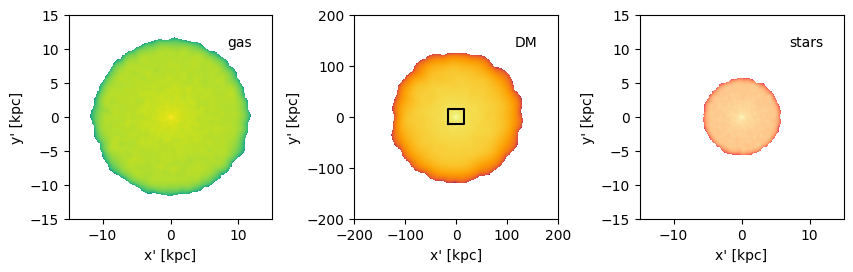

In [ ]:
myvis(sg)

## Overview of features

### `SWIFTDataset` features

`SWIFTGalaxy` is built upon `swiftsimio` and takes advantage of all the features of the `SWIFTDataset` class, notably "lazy loading" of particle data. A `SWIFTGalaxy` inherits from the `SWIFTDataset` class, and should therefore in principle be accepted by functions expecting a `SWIFTDataset` (in practice there still some work to do on this front, e.g. some adjustments needed for some functions from the `swiftsimio.visualisation` module).

### Automatic recentering

When the `SWIFTGalaxy` is created, the coordinates are automatically centred on the position and velocity (according to the halo finder) of the galaxy of interest. In case there are multiple centres defined, as with `Velociraptor` (minimum potential, centre of mass, etc.), which one to use is configurable. The automatic recentering can also be disabled entirely, or the centre of another `SWIFTGalaxy` can be used (can be useful e.g. for putting a satellite in the coordinate frame of its central).

### Rotation & other coordinate transformations

The particles in a `SWIFTGalaxy` always occupy a common coordinate frame, such that e.g. all particles rotate together. Rotations, translations (in position) and boosts (translations in velocity) are all supported. As an example, we can rotate our galaxy. To specify a rotation, the [`scipy.spatial.transform.Rotation`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) class is used. This accepts rotation matrices, Euler angles, and more.

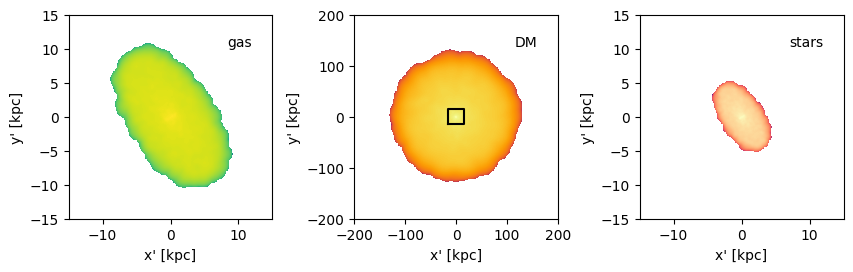

In [ ]:
from scipy.spatial.transform import Rotation

sg.rotate(Rotation.from_euler("xy", [60, 30], degrees=True))
myvis(sg)

Let's reverse the rotation before continuing with the examples.

In [ ]:
sg.rotate(Rotation.from_euler("yx", [-30, -60], degrees=True))

### Additional coordinates

When working with a galaxy it is often convenient to work in spherical or cylindircal coordinates. These are built into a `SWIFTGalaxy` and are evaluated lazily as and when needed. Their consistency when the coordinate frame is transformed is also ensured. As an illustrative example, we can plot the azimuthal velocity against the radial velocity - the figure in which the Gaia-Enceladus (or "sausage") structure in the Milky Way was identified. Of course our crude model galaxy won't have any such interesting structure - indeed the disc isn't even actually rotating!

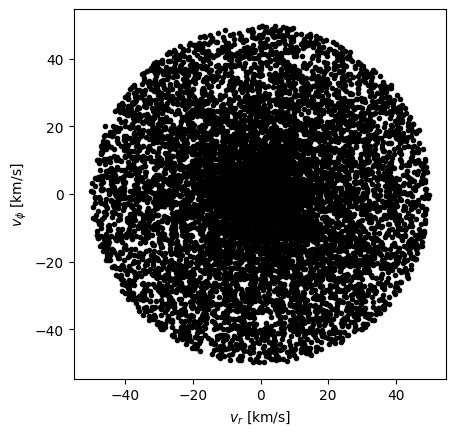

In [ ]:
plt.plot(
    sg.stars.spherical_velocities.r.to_value(u.km / u.s),
    sg.stars.spherical_velocities.phi.to_value(u.km / u.s),
    ".k",
    rasterized=True,
)
plt.xlabel(r"$v_r$ [km/s]")
plt.ylabel(r"$v_\phi$ [km/s]")
plt.gca().set_aspect("equal")

### Particle masking

`SWIFTGalaxy` enables selecting subsets of particles in intuitive, syntactically simply ways (beyond what's supported by `swiftsimio`, actually). As an example, we can chop a hole out of the centre of the stellar and gas discs:

/usr/local/lib/python3.10/dist-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor ((a**2)**0.5 at a=1.0) for all arguments.
  warnings.warn(


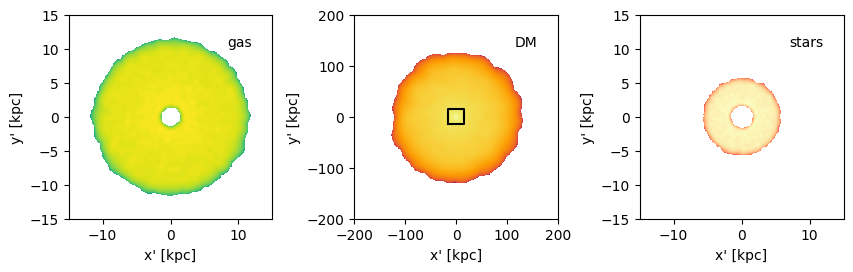

In [ ]:
from swiftgalaxy import MaskCollection

sg.mask_particles(
    MaskCollection(
        gas=sg.gas.cylindrical_coordinates.R > 2 * u.kpc,
        stars=sg.stars.cylindrical_coordinates.R > 2 * u.kpc,
    )
)
myvis(sg)

The mask applies to all particle properties, e.g. if we next loaded the gas temperatures they would be masked to match. It's also possible to obtain masked particle datasets (copies!) with `sg.gas[...]`, amongst other options.

### Halo finders & integrated properties

For now only `Velociraptor` is supported, but I plan on adding `SOAP` and possibly others on request.

The [velociraptor-python](https://velociraptor-python.readthedocs.io/en/latest/) halo catalogue is exposed through the `halo_finder` attribute of a `SWIFTGalaxy`, and only the properties of the particular galaxy of interest are loaded. This makes accessing integrated properties particularly convenient:

In [ ]:
print(sg.halo_finder)
print(sg.halo_finder.radii)
print("R200c =", sg.halo_finder.radii.r_200crit.to(u.kpc))

Masked velociraptor catalogue at toyvr.properties. Contains the following field collections: snia_rates, metallicity, ids, energies, stellar_age, spherical_overdensities, rotational_support, star_formation_rate, masses, eigenvectors, radii, temperature, veldisp, structure_type, velocities, positions, concentration, rvmax_quantities, angular_momentum, projected_apertures, apertures, element_mass_fractions, dust_mass_fractions, number, hydrogen_phase_fractions, black_hole_masses, stellar_birth_densities, snii_thermal_feedback_densities, species_fractions, gas_hydrogen_species_masses, gas_H_and_He_masses, gas_diffuse_element_masses, dust_masses_from_table, dust_masses, stellar_luminosities, cold_dense_gas_properties, log_element_ratios_times_masses, lin_element_ratios_times_masses, element_masses_in_stars, fail_all
Contains the following fields: r_200crit, r_200mean, r_bn98, r_size, rmax, rvir
R200c = 300.0 kpc


### Documentation

Detailed documentation for `swiftgalaxy` is [hosted on readthedocs](https://swiftgalaxy.readthedocs.io/en/latest/halo_finders/index.html).

# Cleanup sample snapshot and halo finder output

In [ ]:
remove_toysnap()
remove_toyvr()